In [ ]:
import sys
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, signal, sparse
from scipy.signal import windows

sys.path.insert(0,'..')
from convolver import BGPCResp, NumericalGIRF

from skope_utils import get_A_spherical, get_b0_comp, re_sort_kdata

DATA_DIR = Path('F:\\data\\2025_0327_SkopeGIRFPos\\Skope_scan_20250327\\')

In [2]:
def get_single_hdata(kdata, gdata, i_ax, i_fit, Nf0 = 1000, Nf1 = -1, do_b0=False):
    
    all_x = []
    all_y = []
        
    for i_wave_type in range(kdata.shape[0]):
        for i_wave in range(kdata.shape[1]):
            x = gdata[i_wave_type, i_wave, 2]  # 2 is polarity positive
            y = (kdata[i_wave_type, i_wave, 2] - kdata[i_wave_type, i_wave, 0]) / 2.0
            
            if i_fit == 0 and do_b0:
                b0_comp = get_b0_comp(x/42576000/2/np.pi/100, y, wave_dir=i_ax)
                y += b0_comp
                
            if Nf1 > 0:
                filt0 = windows.kaiser(2*Nf0, 12)
                filt1 = windows.kaiser(2*Nf1, 12)

                filt0 = filt0[:Nf0]
                filt1 = filt1[Nf1:]
                
                filt_decay = np.hstack([filt0, np.ones(y.size-Nf0-Nf1), filt1])
                
                y *= filt_decay
                x *= filt_decay

            all_x.append(x)
            all_y.append(y)

    return np.array(all_x), np.array(all_y)

def get_double_hdata(kdata, gdata, i_ax, i_fit, do_b0=False):
    
    all_x = []
    all_y = []
        
    for i_wave_type in range(kdata.shape[0]):
        for i_wave in range(kdata.shape[1]):
            for polarity in [0, 2]:
                x = gdata[i_wave_type, i_wave, polarity]  # 2 is polarity positive
                y = kdata[i_wave_type, i_wave, polarity]
                
                if i_fit == 0 and do_b0:
                    b0_comp = get_b0_comp(x/42576000/2/np.pi/100, y, wave_dir=i_ax)
                    y += b0_comp

                all_x.append(x)
                all_y.append(y)

    return np.array(all_x), np.array(all_y)

In [3]:
gdata = np.load(DATA_DIR / 'g_out2.npz')['g_out']
gdata *= 2*np.pi
print(f'{gdata.shape = }')

gdata.shape = (3, 12, 3, 100000)


In [4]:
ksp = ['16p_k4_sfit16_areg.npz', 1, partial(get_A_spherical, add_concomittant=False)]

if ksp[1] >= 0:
        kdata = np.load(DATA_DIR / ksp[0])['ksp'][ksp[1]]
else:
    kdata = np.load(DATA_DIR / ksp[0])['ksp']

print(f'{ksp[2](0,0,0).size==kdata.shape[1]}    {kdata.shape = }    {ksp[2](0,0,0).size}')

kdata = re_sort_kdata(kdata, [3,3,12,3])

True    kdata.shape = (100000, 16, 324)    16
new_shape = array([     3,      3,     12,      3,     16, 100000])


In [5]:
sos = signal.bessel(3, 10000, 'lp', fs=1/1e-6, output='sos')
kdata_f = kdata.copy()
kdata_f = signal.sosfiltfilt(sos, kdata_f)
kdata_f = np.gradient(kdata_f, axis=-1)/1e-6

print(f'{kdata_f.shape = }')

kdata_f.shape = (3, 3, 12, 3, 16, 100000)


In [70]:
i_ax = 2
i_fit = 0

all_x, all_y = get_single_hdata(kdata_f[i_ax, :, :, :, i_fit], gdata, i_ax, i_fit)
all_x = all_x[:,::10]
all_y = all_y[:,::10]

for i in range(all_x.shape[0]):
    shift = 1400
    all_y[i] = np.pad(all_y[i],[shift, 0])[:-shift]

In [71]:
Nsamp = all_y.shape[1]
print(f'{Nsamp = }')

sTE_DIR = Path('F:\\data\\2025_0306_sTE\\')

extra_op = []
extra_y = []

for scan_idx in [0,1,2,3,4,5,6,7,8,9,22,23]:
    npz = np.load(sTE_DIR / 'coeffs_v1' / f'{scan_idx:03d}.npz')

    g_out = npz['g_out'] * 2 * np.pi  # Units of [rad/s/m^N]
    TE_idx = npz['TE_idx']
    excite_idx = int(npz['excite_idx_in'])
    coeff = npz['coeff']

    tck = interpolate.splrep(TE_idx, coeff[:,i_fit])
    coeff_interp = interpolate.splev(np.arange(TE_idx.min(), TE_idx.max()), tck)/10e-6

    resp_op = BGPCResp(g_out, Nsamp, TE_idx, excite_idx, shift)

    extra_op.append(resp_op)
    extra_y.append(coeff_interp)

Nsamp = 10000


(361230,)


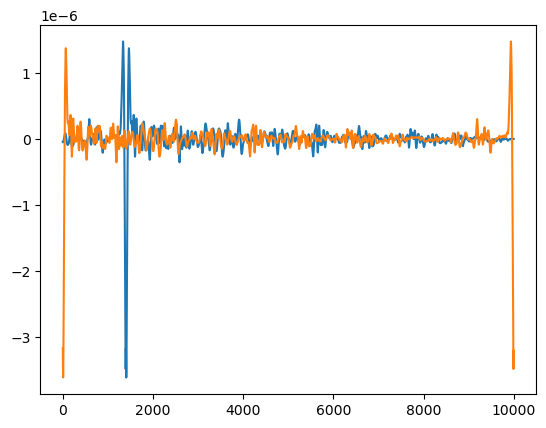

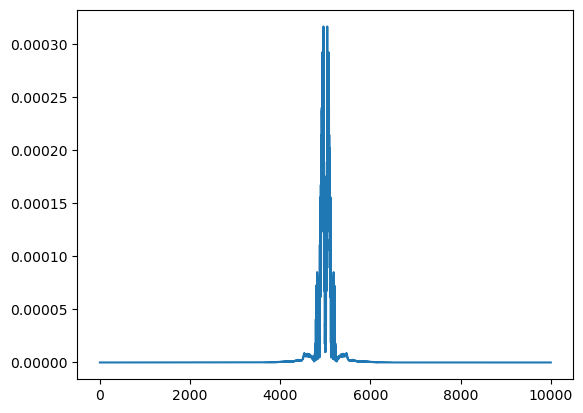

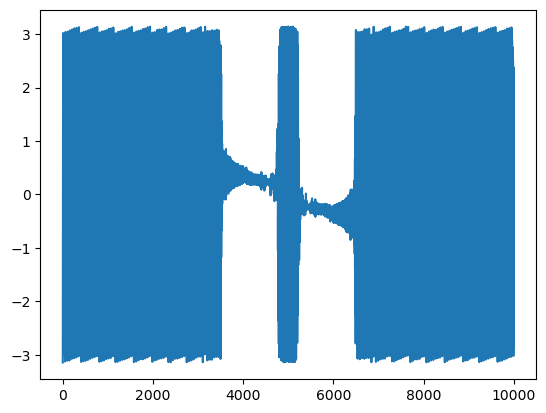

In [73]:
wave_idx = np.arange(36)

girf_ops = NumericalGIRF(all_x[wave_idx], all_y[wave_idx], extra_op=extra_op, extra_y=extra_y)

def mv(x):
    return girf_ops.rmatvec(girf_ops.matvec(x))

girf_linop = sparse.linalg.LinearOperator((all_x.shape[1], all_x.shape[1]),
                                          matvec = mv,
                                          rmatvec = mv,
                                          dtype = all_x.dtype)

maxiter = 1000
y_prob = np.hstack([all_y[wave_idx].ravel(), *extra_y])
print(y_prob.shape)
girf_ops.rmatvec(y_prob)
h_out = sparse.linalg.gmres(girf_linop, girf_ops.rmatvec(y_prob), maxiter=maxiter)[0]

H_out = np.fft.fftshift(np.fft.fft(h_out))

phase_shift = (np.arange(H_out.size)-H_out.size/2)/H_out.size*2*np.pi*shift
phase_shift = np.exp(1j*phase_shift)

H_out = H_out * phase_shift

# dt_ratio = 1/10
# new_size = int(H_out.shape[-1] * dt_ratio)
# dW = (H_out.shape[-1] - new_size) // 2
# H_out = H_out[dW:-dW]


h_out2 = np.real(np.fft.ifft(np.fft.ifftshift(H_out)))

plt.figure()
plt.plot(h_out)
plt.plot(h_out2)

plt.figure()
plt.plot(np.abs(H_out))

plt.figure()
plt.plot(np.angle(H_out))

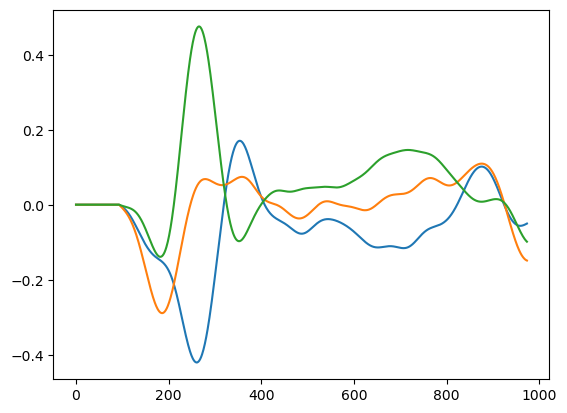

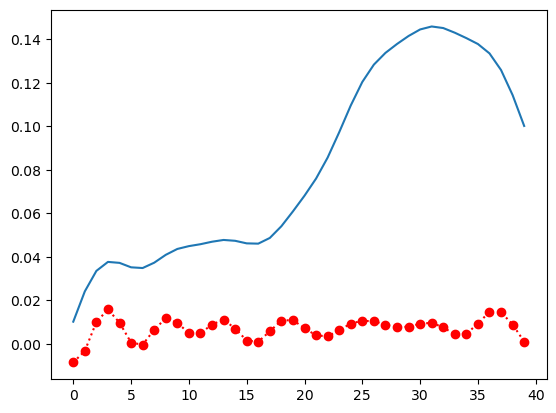

In [75]:
Nsamp = h_out.size

sTE_DIR = Path('F:\\data\\2025_0306_sTE\\')
scan_idx = 23
npz = np.load(sTE_DIR / 'coeffs_v1' / f'{scan_idx:03d}.npz')

g_out = npz['g_out'] * 2 * np.pi  # Units of [rad/s/m^N]
TE_idx = npz['TE_idx']
excite_idx = int(npz['excite_idx_in'])
coeff = npz['coeff']

N_TR = g_out.size//2

gg_tile = np.tile(g_out, 30)
gg_tile = gg_tile[-Nsamp:]

X = np.fft.fftshift(np.fft.fft(gg_tile))
Y = X*H_out
y = np.real(np.fft.ifft(np.fft.ifftshift(Y)))

dt = 10e-6
y_c = y[-4*N_TR:-2*N_TR]
y_c = y[-2*N_TR:]

ph1_0 = dt*np.cumsum(y_c[excite_idx:N_TR])
ph1_1 = dt*np.cumsum(y_c[excite_idx+N_TR:2*N_TR])

response1 = ph1_1-ph1_0
response1 = np.hstack([np.zeros(excite_idx), response1])

plt.figure()
plt.plot(np.hstack([np.zeros(excite_idx), ph1_0]))
plt.plot(np.hstack([np.zeros(excite_idx), ph1_1]))
plt.plot(response1)

plt.figure()
plt.plot(response1[TE_idx])
plt.plot(coeff[:,i_fit], marker='o', ls=':', color='r')


win_width = np.int64(390)
i_excite0 = 8068  i_excite1 = 9081
(390,) 390


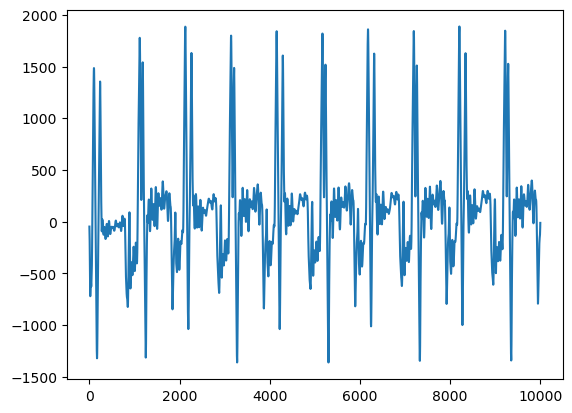

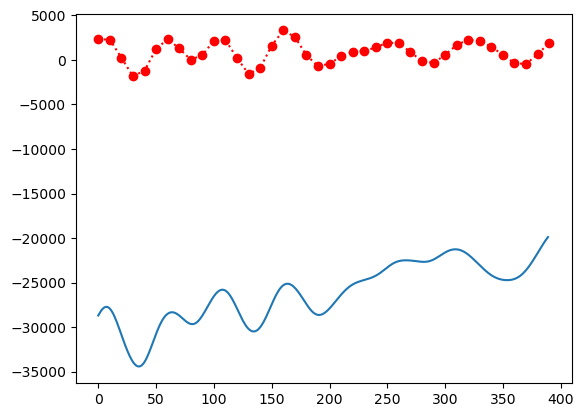

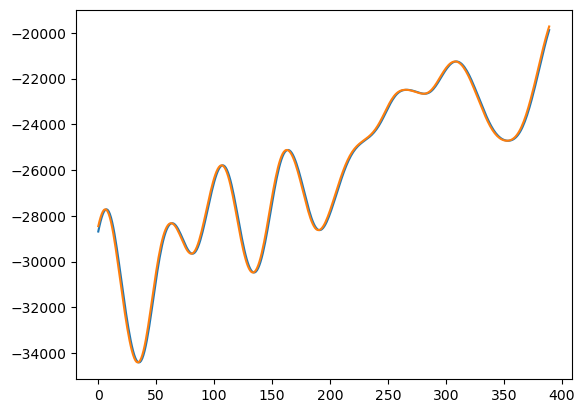

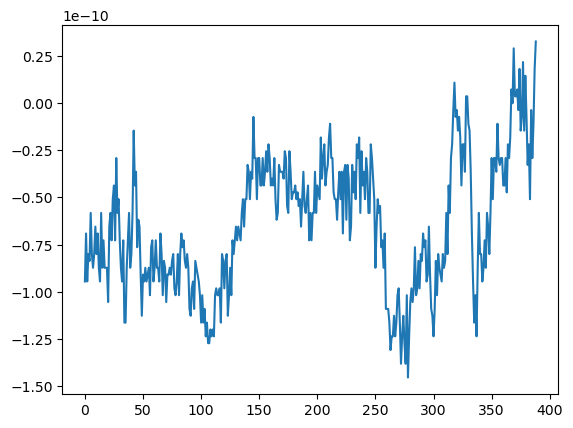

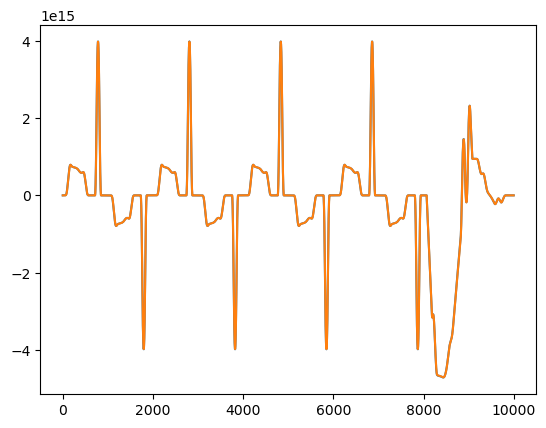

In [191]:
Nsamp = h_out.size

A = np.zeros([Nsamp, Nsamp], np.float64)
for i in range(1, Nsamp+1):
    A[i-1, :i] = gg_tile[i-1::-1]
    
y0 = A@h_out

plt.plot(y0)

win_width = TE_idx.max()-TE_idx.min()
print(f'{win_width = }')

i_excite0 = gg_tile.size-2*N_TR + excite_idx + shift
i_excite1 = i_excite0 + N_TR

print(f'{i_excite0 = }  {i_excite1 = }')

S = np.zeros([win_width, gg_tile.size])
for i in range(win_width):
    S[i,i_excite0:i_excite0+TE_idx.min()-excite_idx+i] = -1
    S[i,i_excite1:i_excite1+TE_idx.min()-excite_idx+i] = 1
    
    
SA = S@A

plt.figure()
plt.plot(SA@h_out)
plt.plot(TE_idx-TE_idx.min(), coeff[:,i_fit]/dt, marker='o', ls=':', color='r')

# plt.figure()
# plt.plot(np.abs(A).sum(0))

# plt.figure()
# plt.plot(np.abs(SA).sum(0))
# plt.plot(gg_tile)

# plt.figure()
# plt.plot(all_y[0])


resp_op = BGPCResp(g_out, Nsamp, TE_idx, excite_idx, shift)
y = resp_op.matvec(h_out)
yy = resp_op.rmatvec(y)



plt.figure()
plt.plot(SA@h_out)
plt.plot(y)

plt.figure()
plt.plot((SA@h_out)[1:] - y[:-1])

plt.figure()
plt.plot(SA.T@SA@h_out)
plt.plot(yy)

print(y.shape, resp_op.win_width)

In [195]:
e = np.array([[1,1,1,1], [2,2,2,2], [3,3,3,3]])
print(e.shape)

extra_y = [4*np.ones(1), 5*np.ones(5)]

np.hstack([e.ravel()] + extra_y)

(3, 4)


array([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 4., 5., 5., 5., 5.,
       5.])